# Clasificación de preguntas de clientes - Santander

En Santander tenemos por misión contribuir al progreso de las personas y las empresas. Debido a ello buscamos constantemente nuevas formas de entender al cliente, con el objetivo de consolidar vínculos a largo plazo.

Nuestro equipo de Advanced Analytics & Machine Learning se encuentra en continua mejora de sus algoritmos y modelos. Basándonos en esta premisa, decidimos abrir nuestros datos e invitar a la comunidad a identificar nuevas formas de entender las preguntas y reclamos de nuestros clientes, utilizando un motor de NLU (Natural Language Understanding).

Esta competencia tiene como objetivo desarrollar un algoritmo de clasificación que, utilizando técnicas de NLP (Natural Language Processing), sea capaz de entender la intención de un cliente (target) al momento de realizar una pregunta (predictor) en alguno de los canales del Banco.

# Descripción
Se disponen de tres datasets:

- training.csv: reúne la información del caso, el mismo tiene dos columnas:
    - Pregunta: pregunta realizada por el cliente. (String)
    - Intención: intención de la pregunta realizada, contiene 350 intenciones aproximadamente. (String)

- test.csv: solo contiene la pregunta realizada por el cliente.

- primer_submit.csv: este archivo tiene el formato en el que se deben enviar las predicciones.

# Evaluación
La evaluación consta de dos partes:

1 - **Score de predicciones**: los resultados serán medidos utilizando la métrica **Balance Accuracy**. En el leaderboard se puede ver el mejor score público del total de submits de cada participante. El mismo se calcula con una porción de los datos de test. Metadata se reserva el score privado para la evaluación final.

El archivo con predicciones que se debe submitear debe esta en formato csv sin encabezado y debe contar de dos columnas. La primer columna corresponde al 'id' de la pregunta hecha por el cliente en el archivo de test. La segunda a la categoría predicha en formato de entero, es decir, si la predicción es cat_101 (string) debe reportar solamente 101 (int). Para ver un ejemplo puede mirar el archivo primer_submit en las solapa Datos.

2 - **Informe**: Al finalizar la competencia se pedirá a los primeros 10 competidores en el ranking de predicciones un informe adicional, donde se explique el modelo y la metodología aplicada. La nota la otorgará un jurado ad-hoc de especialistas en el tema evaluando el informe sobre el trabajo realizado con el análisis de contrastación entre los datos reales y los datos generados por los modelos.

Finalmente, el score total que determinará los ganadores se compondrá en un 70% por el score privado conseguido con la predicción medida con la métrica especificada y el 30% restante se sumará con el informe.

Importante: tanto Santander como Metadata se reservan el derecho a pedir el código para poder evaluar el modelo y evitar soluciones tramposas. En caso de que se le requiera el código a un participante y no lo envíe, será descalificado de forma inmediata.

In [1]:
import os
import sys
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re
from gensim.models import KeyedVectors
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from joblib import load, dump
from keras.metrics import categorical_accuracy
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LSTM,SpatialDropout1D, GRU, Bidirectional, TimeDistributed, BatchNormalization
import gc
from imblearn import FunctionSampler
from sklearn.utils import class_weight
import keras.backend as K
import fasttext
from spacy.lang.es import Spanish

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df = pd.read_csv('./train.csv', sep='|')

In [4]:
df.shape

(20104, 2)

In [5]:
df.head()

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342


In [6]:
df.isna().sum()

Pregunta     0
Intencion    0
dtype: int64

In [7]:
val_counts = pd.DataFrame(df.Intencion.value_counts())
val_counts.tail(5)

,Intencion
Cat_13,3
Cat_15,3
Cat_11,3
Cat_24,2
Cat_104,1


In [8]:
#DESDE ACA:

In [9]:
val_counts_df = pd.DataFrame(df.Intencion.value_counts())
relevant_classes = val_counts_df[val_counts_df.Intencion > 1].index
print(relevant_classes.shape[0] / df.Intencion.nunique())

0.9971590909090909

In [10]:
relevant_classes.shape[0]

351

In [11]:
df = df[df.Intencion.isin(relevant_classes)]

In [12]:
df.shape

(20103, 2)

In [13]:
#lens = [len(x.split(" ")) for x in df.Pregunta.values]
#df['len'] = np.array(lens)
#df = df[df.len < 20]

In [14]:
TEST_SPLIT = 0.15
FILTER_SIZES = [1,2,3]
NUM_FILTERS = 512
DROPOUT = 0.5
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 10

In [15]:
def balanced_recall(y_true, y_pred):
    """
    Computes the average per-column recall metric
    for a multi-class classification problem
    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)  
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)   
    recall = true_positives / (possible_positives + K.epsilon())    
    balanced_recall = K.sum(recall, axis=0)/K.cast(K.shape(recall)[0], recall.dtype)
    return balanced_recall

In [16]:
class text_preprocessor():
    
    def __init__(self, test_split = 0.2, pad_with = 'max_len'):
        '''
        Pad with can be: 'max_lenght', 'avg_lenght' or int number
        ''' 
        if (pad_with not in ('max_len','avg_len')) and (type(pad_with) is not int):
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        self.tokenizer = Tokenizer()
        self.test_split = test_split
        self.pad_with = pad_with
        self.pad_text_to = None
        self.nlp = Spanish()
        self.y_label_encoder = OneHotEncoder(sparse=False)
        self.transform_dict = {
            'k':'que',
            'q':'que',
            'xq': 'por que',
            'x': 'por',
            'wsp':'whatsapp',
            'wasap':'whatsapp',
            'watsap':'whatsapp',
            'vergüenza' : 'verguenza',
            'gcs':'gracias',
            'gxs':'gracias',
            'grax':'gracias',
            'nesecito': 'necesito',
            'tageta':'tarjeta',
            'psuper': 'super',
            'hombamnkin': 'home banking',
            'usd': 'dolares',
            'invercion': 'inversion',
            'buscartenencias': 'buscar tenencias',
            'debit':'debito',
            'nro':'numero',
            'ala': 'a la',
            'cel':'celular',
            'prstamo':'prestamo',
            'paguemi': 'pague mi',
            'tc':'tarjeta de credito',
            'agip': 'impuestos',
            'afip': 'impuestos',
            'dnrpa': 'impuestos',
            'metrogas': 'empresa servicio gas',
            'aysa': 'servicio agua',
            'dnrpa': 'registro propiedad automotor impuestos',
            'iibb': 'impuestos ingresos brutos',
            'directv': 'empresa servicios television',
            'naranja':'empresa servicios financieros',
            'internet': 'servicios internet',
            'movistar':'empresa servicios telefonia',
            'edenor':'servicios electricidad',
            'bus': 'servicios autobus',
            'redbus':'servicios autobus',
            'gas': 'servicios gas',
            'epec':'empresa servicios electricidad',
            'luz':'servicios electricidad',
            'vep':'impuestos voleto electronico de pago',
            'expensas':'impuestos expensas',
            'cel': 'celular',
            'recargar': 'pagar',
            'monotributo': 'impuestos monotributo',
            'edesur':'empresa servicios electricidad',
            'fibertel':'empresa servicios internet',
            'aduana':'impuestos aduana',
            'recarga':'pagar',
            'patentar':'impuestos patente',
            'cmo':'como',
            'women':'mujer',
            'woman':'mujer',
            'transferi':'transferencia',
            'advantage':'programa ventaja beneficios',
            'contactless': 'sin contacto',
            'contacless':'sin contacto',
            'contactles': 'sin contacto',
            'ahora12': 'ahora doce',
            'vivienda': 'casa',
            'propiedad': 'casa',
            'letes': 'acciones',
            'bonos': 'acciones',
            'workcafe': 'trabajo cafe',
            'sé': 'saber',
            'coworking': 'trabajo cafe',
            'porq': 'por que',
            'num':'numero',
            'porq': 'por que',
            'cualew': 'cuales',
            'fci': 'fondo comun de inversion',
            'priority': 'prioritario',
            'vip': 'prioritario',
            'pas': 'entrada',
            'pass': 'entrada',
            'visahome': 'visa home',
            'sertificado': 'certificado',
            'comitente': 'custodia',
            'desisto': 'desisto cancelo',
            'desistir':'desistir cancelar',
            'desisti':'desisti cancelar',
            'pensiones': 'pensiones jubilados',
            'pensionado': 'pensionado jubilado',
            'cuit': 'cuit datos direccion codigo unico de identificacion tributaria',
            'debin': 'debito inmediato',
            'credin': 'credito inmediato',
            'open':'abierto',
            'credit':'credito',
            'movieclub': 'club peliculas',
            'lavoz': 'diario la voz',
            'ia': 'inteligencia artificial',
            'bot': 'robot virtual inteligencia artificial',
            'veras': 'veraz deuda',
            'veraz': 'veraz deuda',
            'value': 'valor',
            'dining': 'comida',
            'concergerie': 'conserjeria',
            'concierge': 'conserjeria',
            'checkin':'registro',
            'aeroparque': 'aeropuerto',
            'ezeiza': 'aeropuerto',
            'voucher': 'vale',
            'extración': 'extraccion',
            'extracion': 'extraccion',
            'amex': 'tarjeta',
            'cuantosaaños': 'cuantos años',
            'lebacs': 'acciones',
            'lollapalooza': 'festival',
            'lolla': 'festival',
            'lolapaloza': 'festival',
            'cbu': 'clave bancaria uniforme',
            'cuil': 'codigo unico identificacion laboral',
            'bonar': 'bonos',
            'merval': 'bonos',
            'uva': 'bonos',
            'ypf': 'empresa petrolera',
            'petrobras': 'empresa petrolera',
            'teco': 'empresa servicios telefonia',
            'ceco':'empresa servicios energia',
            'aluar': 'empresa aluminio',
            'edenor': 'empresa servicios energia',
            'consultatio': 'consultatio inversiones',
            'caputo': 'acciones caputo',
            'visahome': 'sitio web visa home',
            'targeta': 'tarjeta',
            'targetas': 'tarjetas',
            'todopago': 'todo pago billetera virtual',
            'app': 'aplicacion movil',
            'holis': 'hola',
            'holi':'hola',
            'holas': 'hola',
            'holus': 'hola',
            'sms': 'mensaje de texto',
            'bye': 'chau',
            'chauchis': 'chau',
            'chauchi': 'chau',
            'adios': 'chau',
            'byebye': 'chau',
            'chauchu':'chau',
            'fembot': 'mujer',
            'chica': 'mujer',
            'chico': 'hombre',
            'muchacha': 'mujer femenina',
            'muchacho': 'hombre masculino',
        }
        self.frases_dict = {
            'dar de baja': 'dar de baja cancelar',
            'red bus': 'servicios autobus',
            'tarjeta sube': 'servicios autobus',
            'la sube': 'servicios autobus',
            'ahora 12': 'ahora doce',
            'ahora 18': 'ahora diesiocho',
            'me llamo': 'mi nombre es',
            'la voz': 'diario la voz',
            'club la nacion': 'club diario la nacion',
            'darme de baja': 'darme de baja cancelar',
            'dar la baja': 'dar la baja cancelar',
            'clarin': 'diario clarin',
            'clarín': 'diario clarin',
            '365': 'tarjeta diario clarin',
            'quiero la baja':'quiero la baja cancelar',
            'que no conozco': 'que no conozco desconocida',
            'súper ordenador': 'super ordenador virtual inteligente',
            'asistente virtual': 'asistente virtual inteligente',
            'check in': 'registro',
            'american express': 'tarjeta',
            'american expres': 'tarjeta',
            'tarjeta sube':'servicios autobus',
            'co working': 'trabajo cafe'
        }
        self.non_important_words = ['abuela','florestaahora','tio','hijo','hermana','hermano',
                       'quiero','quisiera','queria', 'mama', 'papa', 'mamá','papá',
                       'favor','chaco', 'avda', 'santa', 'fe', 'belgrano', 'av','cabildo']
        
        self.important_words = ['no', 'puedo','dos','veces','pagar','debitar','querer','gracias','saber','que','mayor',
                   'color', 'casa', 'donada','veo', 'ver','otros','sin', 'poder','nunca','tipo','sos','menor',
                   'cuenta','como','te','va','onda','tal','se','dias','tiempo','usar', 'cuando','voz','buenos',
                    'como','esta', 'donde','sabes','saber', 'puedo', 'podes','hola', 'buenas', 'tardes','buen',
                   'tengo','el', 'ella',]
    def fit_transform(self, df):
        # Data Preparation
        x_text, y = self.make_dataset(df)
        
        # Build vocabulary
        if self.pad_with == 'max_len':
            max_text_lenght = max([len(x.split(" ")) for x in x_text])
            self.pad_text_to = max_text_lenght
        elif self.pad_with == 'avg_len':
            avg_text_lenght = int(np.mean([len(x.split(" ")) for x in x_text]))
            self.pad_text_to = avg_text_lenght
        elif type(self.pad_with) is int:
            self.pad_text_to = self.pad_with
        else:
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        
        self.tokenizer.fit_on_texts(x_text)
        sequences =  self.tokenizer.texts_to_sequences(x_text)
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        print("Vocabulary Size : {}".format(vocab_size))
        x = pad_sequences(sequences, maxlen=self.pad_text_to) # Pad with 0.0 (default pad_sequences value)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.test_split, random_state=42,stratify=y)
        
        del x, y

        print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
        return x_train, y_train, vocab_size, word_index, x_test, y_test, x_text
   
    def transform(self, text):
        stripped = [s.strip() for s in text]
        clean = [self.clean_str(sent) for sent in stripped]
        sequences = self.tokenizer.texts_to_sequences(clean)
        x = pad_sequences(sequences, maxlen=self.pad_text_to)
        return x
    
    def get_padded_text_len(self):
        if self.pad_text_to is not None:
            return self.pad_text_to
        else:
            raise Exception("ERROR: pad_text_to is not set. Must fit before get_padded_text_len")
    
    def replace_words(self, s, words):
        for k, v in words.items():
            s = s.replace(k, v)
        return s

    def clean_str(self,text):
        s = []
        text = self.replace_words(text, self.frases_dict)
        duplicates_to_remove = "abdefghijkmnñopqstuvwxyz" #remove duplicate chars exept for l, r and c
        text = re.sub(r'[^[:alpha:]\s]+', '', text)
        text = re.sub(r'(\w)\1{2,}', r'\1', text) #3 chars
        text = re.sub("(?P<char>[" + re.escape(duplicates_to_remove) + "])(?P=char)+", r"\1", text)
        text = re.sub(r",", " , ", text)
        text = re.sub(r"\.", " . ", text)
        text = re.sub(r"\/", " / ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\(", " \( ", text)
        text = re.sub(r"\)", " \) ", text)
        text = re.sub(r"\?", " \? ", text)
        text = re.sub(r"\s{2,}", " ", text) #2 spaces
        text = ''.join(self.transform_dict[w.lower()] if w.lower() in self.transform_dict else w for w in re.split(r'(\W+)', text))

        for tok in self.nlp.tokenizer(text.lower()):
            #not tok.is_stop and 
            if not tok.is_stop and tok.text not in self.non_important_words or tok.text in self.important_words:
                if tok.is_alpha and not (tok.is_digit or len(tok.text) == 1):
                    if not tok.is_ascii:
                        tok = ''.join(c for c in unicodedata.normalize('NFD', tok.lemma_.lower()) if unicodedata.category(c) != 'Mn')                    
                        s.append(tok)
                    else:
                        s.append(tok.lemma_)
        if not s:
            return "emptystring"
        else:
            s = ' '.join(s)
            return s

    def make_dataset(self, df):
        x = df['Pregunta'].values
        y = df['Intencion']
        
        x = [s.strip() for s in x]
        x = [self.clean_str(sent) for sent in x]
        # labels
        y = y.str.extract('(\d+)')
        y = self.y_label_encoder.fit_transform(y)  
        return [x, y]
    
    def get_class_name(self, preds):
        return self.y_label_encoder.inverse_transform(preds)

In [17]:
processor = text_preprocessor(test_split = TEST_SPLIT, pad_with = 'max_len')

In [18]:
processor.clean_str('holaaaa.. aaa  ¬≠¬≠¬≠¬≠como estas santander rio ¬≠banco quiero una tarjeta como hago para sacarla')

'hola santander rio tarjeta como sacarla'

In [19]:
x_train, y_train, vocab_size, word_index, x_test, y_test, x_text = processor.fit_transform(df)

Vocabulary Size : 5273
Train/Test split: 17087/3016


In [20]:
texts_fixed_len = processor.get_padded_text_len()

In [21]:
print("All texts will be padded with {} words".format(texts_fixed_len))

All texts will be padded with 24 words


In [22]:
y_train.shape

(17087, 351)

In [23]:
x_text[:25]

['como puedo santander rio',
 'pagar tarjeta visa querer reintegro',
 'pagar tarjeta empresa servicios financieros sistema',
 'no se debito cuota plan bienes personales saber que',
 'abonar tarjeta credito',
 'se pagar mastercard autoservicios banco',
 'informar que viajar exterior',
 'pasar preguntar seguridad',
 'olvide contrasena home banking',
 'como doy baja tarjeta telefono no comunicarse',
 'poder obtener clave',
 'que supervivencia sucursal floresta ella pilar banco',
 'pagar servicio pagina banco',
 'cobran recibir dolares exterior',
 'ayudas terminar canje no puedo electronica',
 'solicitar el prestamo santander rio',
 'puedo retirar dinero plazo fijo',
 'invertir bolsa acciones pampa energia',
 'saber como recuperar contrasena cajero automatico',
 'necesito pedir reimpresion que tramite tengo que',
 'donde pago cuota prestamo personal',
 'tengo atraso el pago tarjeta',
 'que casas ropa va promo',
 'deseo ver el distribucion plastico',
 'tardar reponer tarjeta debito']

In [24]:
wvecs = fasttext.load_model('./embeddings/cc.es.300.bin')
embeddings_vec_size = wvecs.get_dimension()

In [25]:
embedding_matrix = np.zeros((len(word_index) + 1, embeddings_vec_size))
for word, i in word_index.items():
    try:
        embedding_vector = wvecs.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass # words that are not found in embeddings are filled with all 0

In [63]:
sequence_input = Input(shape=(texts_fixed_len,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            embeddings_vec_size,
                            weights=[embedding_matrix],
                            input_length=texts_fixed_len,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)
drop_frozen = SpatialDropout1D(0.5)(embedded_sequences_frozen)
reshape_frozen = Reshape((texts_fixed_len,embeddings_vec_size,1))(drop_frozen)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            embeddings_vec_size,
                            weights=[embedding_matrix],
                            input_length=texts_fixed_len,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)
drop_train = SpatialDropout1D(0.5)(embedded_sequences_train)
reshape_train = Reshape((texts_fixed_len,embeddings_vec_size,1))(drop_train)

l_conv_4f = Conv2D(filters=128, 
                    kernel_size=(1, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_frozen)
l_mpool_4f = MaxPool2D(pool_size=(texts_fixed_len - 1 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_4f)
l_conv_4f = Dropout(0.5)(l_mpool_4f)

l_conv_4t = Conv2D(filters=128, 
                    kernel_size=(1, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_train)
l_mpool_4t = MaxPool2D(pool_size=(texts_fixed_len - 1 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_4t)
l_conv_4t = Dropout(0.5)(l_mpool_4t)

l_conv_3f = Conv2D(filters=128, 
                    kernel_size=(2, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_frozen)
l_mpool_3f = MaxPool2D(pool_size=(texts_fixed_len - 2 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_3f)
l_conv_3f = Dropout(0.5)(l_mpool_3f)

l_conv_3t = Conv2D(filters=128, 
                    kernel_size=(2, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_train)
l_mpool_3t = MaxPool2D(pool_size=(texts_fixed_len - 2 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_3t)
l_conv_3t = Dropout(0.5)(l_mpool_3t)

l_conv_2f = Conv2D(filters=128, 
                    kernel_size=(3, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_frozen)
l_mpool_2f = MaxPool2D(pool_size=(texts_fixed_len - 3 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_2f)
l_conv_2f = Dropout(0.5)(l_mpool_2f)

l_conv_2t = Conv2D(filters=128, 
                    kernel_size=(3, embeddings_vec_size),
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape_train)
l_mpool_2t = MaxPool2D(pool_size=(texts_fixed_len - 3 + 1, 1),
                       strides=(1),
                       padding='valid')(l_conv_2t)
l_conv_2t = Dropout(0.5)(l_mpool_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t] # 

l_merge_2 = Concatenate(axis=1)(conv_2)

l_flat = Flatten()(l_merge_2)

preds = Dense(351, activation='softmax')(l_flat)

model = Model(sequence_input, preds)
adam = Adam(lr=0.0003)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [64]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 24, 300)      1581900     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 24, 300)      1581900     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 24, 300)      0           embedding_3[0][0]                
____________________________________________________________________________________________

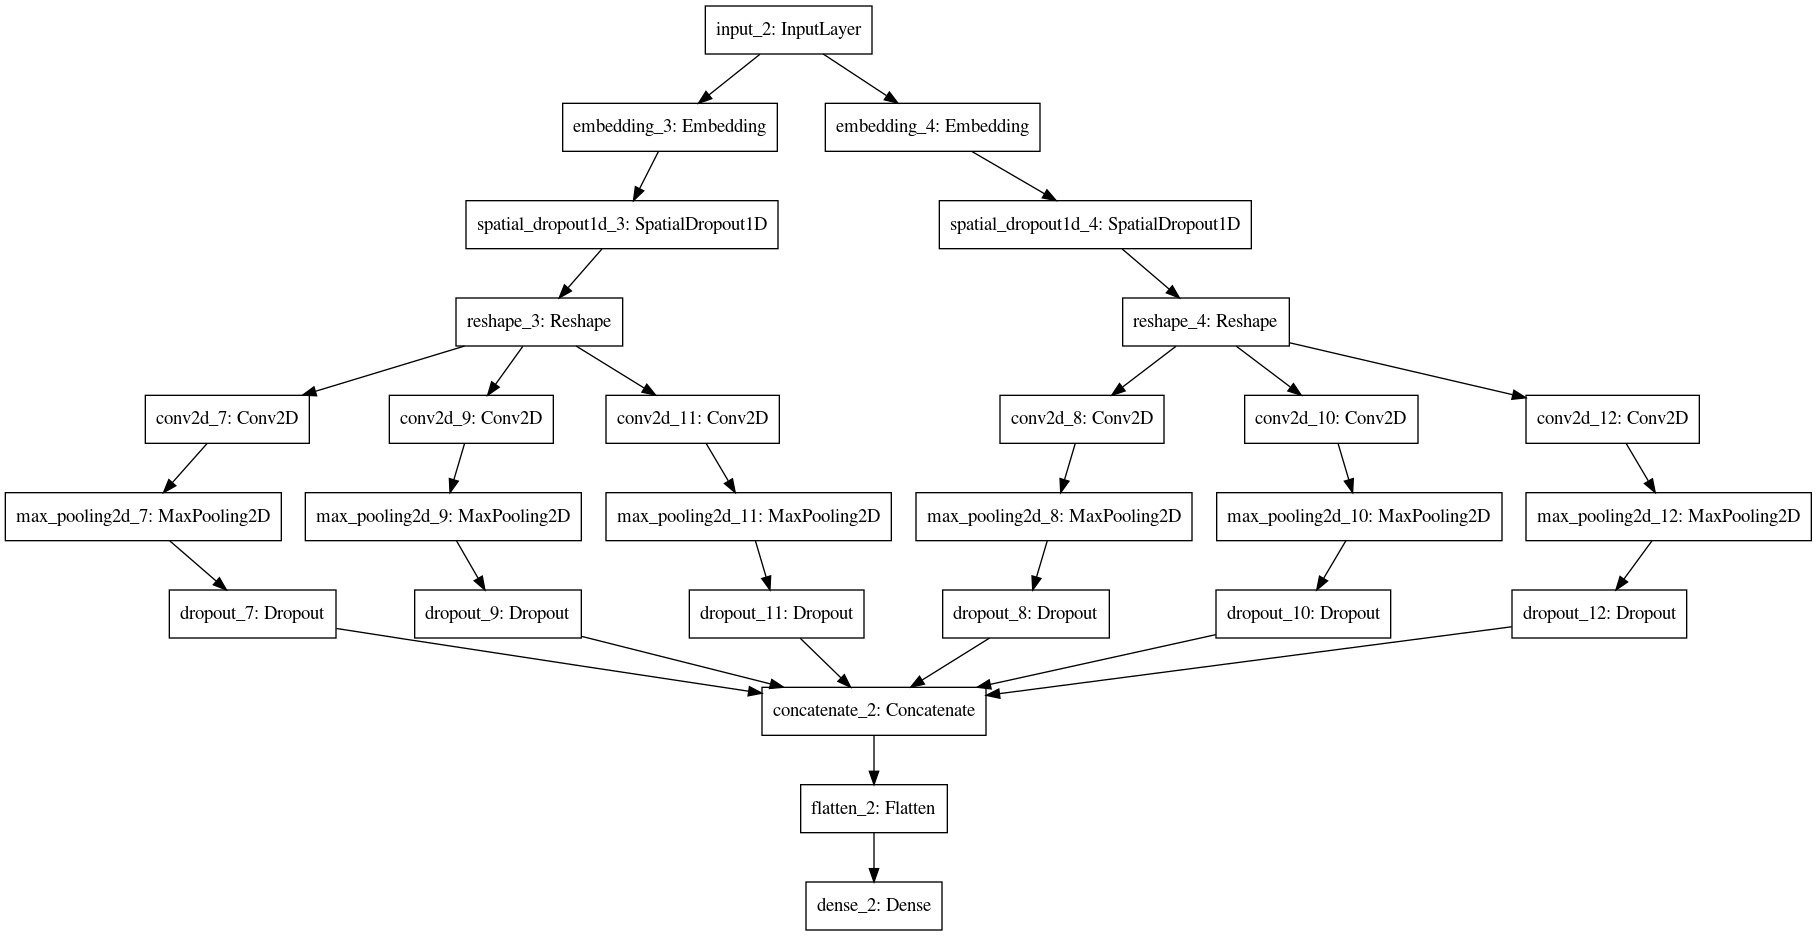

In [65]:
from keras.utils import plot_model
plot_model(model, to_file='text_cnn.png')

In [66]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [67]:
y_classes = np.argmax(y_train, axis=1)

from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y_classes))

# Create integer based labels Series
y_integers = le.transform(list(y_classes))

# Create dict of labels : integer representation
labels_and_integers = dict(zip(y_classes, y_integers))

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

In [68]:
from keras.callbacks import LearningRateScheduler
def initial_boost(epoch):
    #if epoch==0: return float(0.03)
    #elif epoch==1: return float(0.01)
    #elif epoch==2: return float(0.003)
    #elif epoch==3: return float(0.001)
    #else: return float(0.001)
    return float(0.001)

lr_schedule = LearningRateScheduler(initial_boost)

In [69]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.6, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_acc', patience=6, verbose=1)

model_checkpoint = ModelCheckpoint('text_cnn.hdf5',
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')
callbacks=[early_stopping,model_checkpoint,reduce_lr,lr_schedule]

model.fit(x_train, y_train,
          batch_size=512,
          epochs=200,
          callbacks=callbacks,
          validation_data=(x_test, y_test),sample_weight=sample_weights)
#,class_weight=d_class_weights

Train on 17087 samples, validate on 3016 samples
Epoch 1/200
17087/17087 [==============================] - 21s 1ms/step - loss: 5.8662 - acc: 0.0058 - val_loss: 5.7342 - val_acc: 0.0607

Epoch 00001: val_acc improved from -inf to 0.06068, saving model to text_cnn.hdf5
Epoch 2/200
17087/17087 [==============================] - 17s 1ms/step - loss: 5.6589 - acc: 0.0348 - val_loss: 5.5558 - val_acc: 0.1330

Epoch 00002: val_acc improved from 0.06068 to 0.13296, saving model to text_cnn.hdf5
Epoch 3/200
17087/17087 [==============================] - 18s 1ms/step - loss: 5.4339 - acc: 0.0906 - val_loss: 5.2017 - val_acc: 0.1671

Epoch 00003: val_acc improved from 0.13296 to 0.16711, saving model to text_cnn.hdf5
Epoch 4/200
17087/17087 [==============================] - 17s 1000us/step - loss: 5.0768 - acc: 0.1526 - val_loss: 4.6552 - val_acc: 0.2712

Epoch 00004: val_acc improved from 0.16711 to 0.27122, saving model to text_cnn.hdf5
Epoch 5/200
17087/17087 [==============================

### Test

In [33]:
from keras.models import load_model
model = load_model('text_cnn.hdf5')

In [70]:
preds = model.predict(x_test)

In [71]:
preds.argmax(axis=-1)

array([207, 219, 284, ..., 315, 131,  52])

In [72]:
y_test.argmax(axis=1)

array([208, 219, 284, ..., 297, 131,  52])

In [73]:
processor.get_class_name(y_test)

array([['294'],
       ['303'],
       ['39'],
       ...,
       ['50'],
       ['223'],
       ['151']], dtype=object)

In [74]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test.argmax(axis=1), preds.argmax(axis=-1))

0.7572455625724125

# Analysis

In [39]:
x_a = processor.transform(df.Pregunta.values)
y_a = [str(x[4:]) for x in df.Intencion.values]
preds_a = model.predict(x_a)

In [40]:
processor.get_class_name(preds_a).flatten()

array(['102', '350', '132', ..., '192', '218', '56'], dtype=object)

In [41]:
preds_a.shape

(20103, 351)

In [42]:
df['pred'] = processor.get_class_name(preds_a).flatten()

In [43]:
df.head()

,Pregunta,Intencion,pred
0,como puedo trabajar en santander rio,Cat_102,102
1,pagar tarjeta visa querer reintegro,Cat_350,350
2,pagar tarjeta naranja sistema,Cat_132,132
3,no se debitó la primera cuota del plan de bien...,Cat_129,129
4,abonar tarjeta credito,Cat_342,342


In [44]:
df[y_a != processor.get_class_name(preds_a).flatten()].Intencion.value_counts()

Cat_223    47
Cat_39     31
Cat_129    30
Cat_225    30
Cat_132    28
           ..
Cat_46      1
Cat_196     1
Cat_12      1
Cat_148     1
Cat_357     1
Name: Intencion, Length: 222, dtype: int64

In [62]:
df[(df.Intencion == 'Cat_223') & (df.pred == '225')].Pregunta

2020                              cuanto tenía preacordado
4463                                 necesito un prendario
9638         yo soy cliente y quiero un préstamo prendario
11551    queria consultar si podria sacar un prestamo p...
15265    queria consultar si podria sacar un prestamo p...
16419        yo soy cliente y quiero un préstamo prendario
17265    solo queria saber si tengo algún préstamo prea...
18619                                necesito un prendario
Name: Pregunta, dtype: object

In [46]:
df[df.Intencion == 'Cat_225']

,Pregunta,Intencion,pred
52,quisiera saber si estan otorgando creditos per...,Cat_225,225
80,ccredito personal,Cat_225,223
109,ccredito preacordado,Cat_225,225
206,quisiera saber sobre creditos personales,Cat_225,225
405,¿podrías darme información sobre los préstamos...,Cat_225,225
...,...,...,...
19640,cuales son los terminos y condiciones del pres...,Cat_225,225
19707,el prestamo personal puede ser en dolares?,Cat_225,225
19723,si saco el préstamo van a hipotecar la casa en...,Cat_225,225
19930,quiero hacer una consulta sobre los prestamos ...,Cat_225,225


In [47]:
df[(y_a != processor.get_class_name(preds_a).flatten()) & (df.Intencion == 'Cat_248')].head(60)

,Pregunta,Intencion,pred
142,entre a trabajar hace dos meses puedo solicita...,Cat_248,242
3134,puedo obtener un préstamo soy cliente del banco,Cat_248,218
3479,puedo obtener un préstamo soy cliente del banco,Cat_248,218
3816,que necesito para tener ccredito,Cat_248,247
5154,quiero saber si me pueden dar credito,Cat_248,225
5465,puedo sacar el credito prendario?,Cat_248,256
5718,que miran para saber si puedo sacar un hipotec...,Cat_248,236
6049,uno de aaños puede sacar ccredito a aaños?,Cat_248,242
7862,quisiera saber si me pueden dar un préstamo,Cat_248,225
8114,dan préstamos,Cat_248,218


### Subm

In [48]:
val = pd.read_csv('./test_santander.csv', sep=',')

In [49]:
val_prep = processor.transform(val.Pregunta.values)

In [50]:
val_prep.shape

(6702, 24)

In [51]:
val_preds = model.predict(val_prep)

In [52]:
val_preds.shape

(6702, 351)

In [53]:
processor.get_class_name(val_preds).flatten()

array(['303', '303', '311', ..., '199', '138', '337'], dtype=object)

In [54]:
subm = pd.DataFrame({'id':val.id.values, 'pred': processor.get_class_name(val_preds).flatten()})

In [55]:
subm.to_csv('./submissions/text_cnn_v2prep.csv',header=False, index=False)